In [2]:
import torch
import pandas as pd
from torch.autograd import grad
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import astropy.units as u
import gala.potential as gp
from gala.units import galactic

from stream_evolution_potential import NFW, Plummer, run

In [3]:
### First define the Halo and Progenitor ###

halo_mass     = 7.5e11 * u.M_sun
concentration = 20.
flattening_xy  = 1.
flattening_xz  = 1.

halo = NFW(halo_mass, concentration, flattening_xy, flattening_xz)

progenitor_mass = 6.48e8 * u.M_sun # M_sun
alpha = 0.85 * u.kpc # kpc
progenitor = Plummer(progenitor_mass,alpha) 

In [4]:
### Run Stream simulation ###

t_start, t_end, dt = 0, 4, 1e-3 # Gyr
pos_prog = [60, -60, 10] # kpc

pos_scat = [0, 0, 0] # kpc


vel_prog = [0, 100, 0] # km/s
vel_scat = [0, 5, 0] #km/s
N = 2 # amount of star ejected per dt

factor = 1.0 # factor to multiply the tidal radius

time, all_pos_prog, all_vel_prog, all_pos_N, all_vel_N, all_xhi_N, all_rt, all_L1, all_L2 = run(t_start, t_end, dt, halo, progenitor, pos_prog, vel_prog, vel_scat, N, factor)

100%|██████████| 4001/4001 [00:18<00:00, 215.37it/s]


In [7]:
n_orbit   = 250
arg_trail = np.arange(1, 8002, 800)[:-1].astype(int)
arg_lead  = np.arange(0, 8002, 800)[:-1].astype(int)

In [8]:
x_trail = all_pos_N[0, :, arg_trail]
y_trail = all_pos_N[1, :, arg_trail]

x_lead = all_pos_N[0, :, arg_lead]
y_lead = all_pos_N[1, :, arg_lead]

In [28]:
# Ensure that the unwrapped angles are monotonically increasing
def unwrap(angles):
    arg_decrease = np.where( np.diff(angles) <= 0 )[0]
    for i in arg_decrease:
        angles[i+1:] += 2 * np.pi

    return angles

# Get average of a column
def average_column(x,y):
    bins = np.linspace(np.min(x), np.max(x), 101)

    # Bin the x array
    binned_x = np.digitize(x, bins)

    # Create a DataFrame for easy calculation
    df = pd.DataFrame({'x': x, 'y': y, 'bin': binned_x})

    # Group by the bin and calculate mean
    average_y_per_bin = df.groupby('bin')['y'].mean()

    return average_y_per_bin.to_numpy()

# Get the track from the orbits
def get_track_from_orbits(x_pos, y_pos, args):

    first_theta = []
    for index, i in enumerate(args):
        x = x_pos[index, i//2:]
        y = y_pos[index, i//2:]
        first_theta.append(np.arctan2(y[0], x[0]))
    adjust_theta = unwrap( first_theta - first_theta[0])

    x_all = []
    y_all = []
    r_all = []
    theta_all = []
    for index, i in enumerate(args):
        x = x_pos[index, i//2:]
        y = y_pos[index, i//2:]
        x_all.extend(x)
        y_all.extend(y)
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        theta_shifted = theta - theta[0]
        theta_unwrapped = unwrap( theta_shifted + adjust_theta[index])

        r_all.extend(r)
        theta_all.extend(theta_unwrapped)

    r_mean = average_column(theta_all, r_all)
    theta_mean = np.linspace(np.min(theta_all), np.max(theta_all), len(r_mean))
    theta_norm = (theta_mean + first_theta[0] + np.pi) % (2 * np.pi) - np.pi 

    x_mean = r_mean*np.cos(theta_norm)
    y_mean = r_mean*np.sin(theta_norm)

    return x_mean, y_mean

x_track_trail, y_track_trail = get_track_from_orbits(x_trail, y_trail, arg_trail)
x_track_lead, y_track_lead   = get_track_from_orbits(x_lead, y_lead, arg_lead)

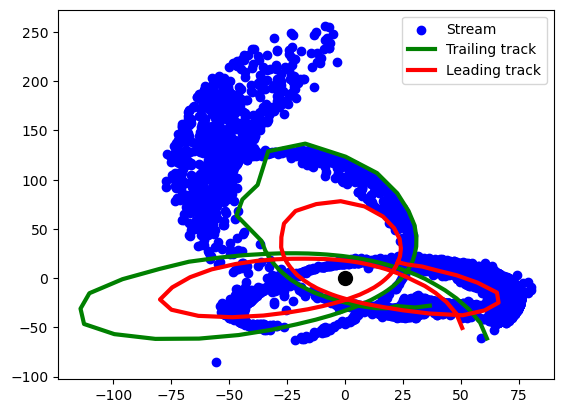

In [30]:
plt.scatter(all_pos_N[0, -1, :], all_pos_N[1, -1, :], c='b',label='Stream')
plt.plot(x_track_trail, y_track_trail, 'g', linewidth=3, label='Trailing track')
plt.plot(x_track_lead, y_track_lead, 'r', linewidth=3, label='Leading track')
plt.scatter(0,0,s=100,color='k')
plt.legend()



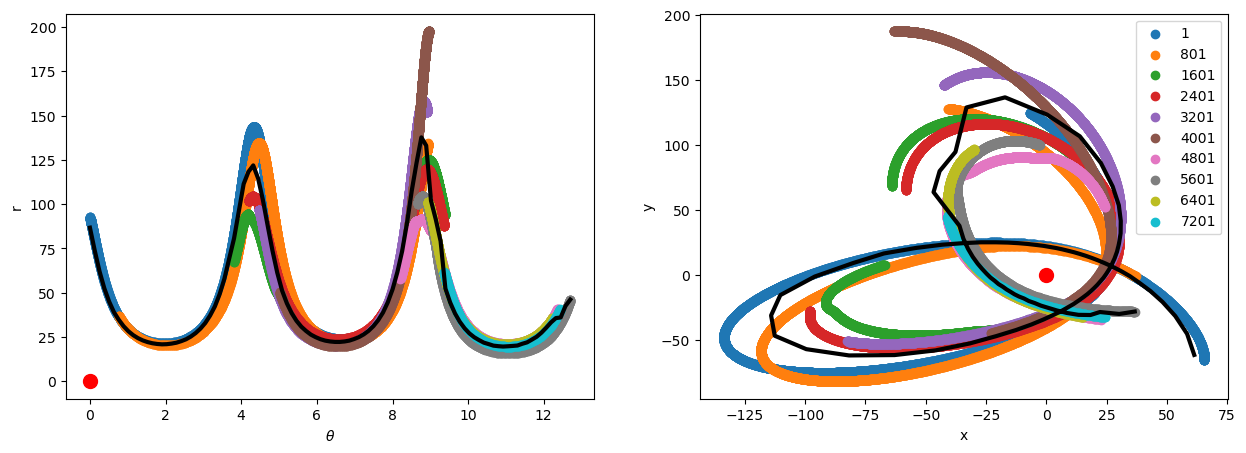

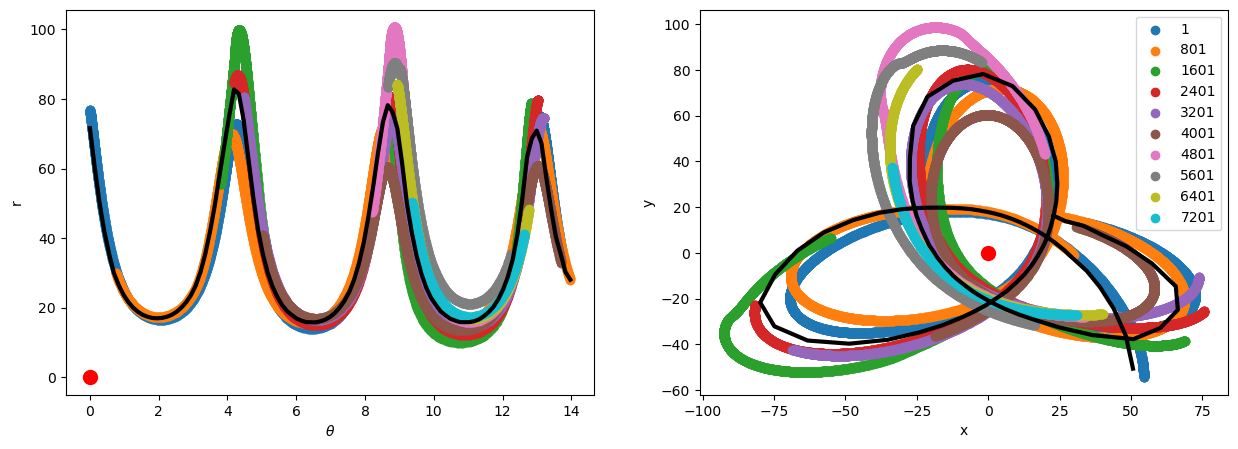

In [38]:
# Get the track from the orbits
def plot_track_from_orbits(x_pos, y_pos, args, mean_bin=51):

    first_theta = []
    for index, i in enumerate(args):
        x = x_pos[index, i//2:]
        y = y_pos[index, i//2:]
        first_theta.append(np.arctan2(y[0], x[0]))
    adjust_theta = unwrap( first_theta - first_theta[0])

    x_all = []
    y_all = []
    r_all = []
    theta_all = []
    for index, i in enumerate(arg_trail):
        x = x_pos[index, i//2:]
        y = y_pos[index, i//2:]
        x_all.extend(x)
        y_all.extend(y)
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        theta_shifted = theta - theta[0]
        theta_unwrapped = unwrap(theta_shifted + adjust_theta[index])

        r_all.extend(r)
        theta_all.extend(theta_unwrapped)

        plt.subplot(1,2,1)
        plt.scatter(theta_unwrapped, r)
        plt.xlabel(r'$\theta$')
        plt.ylabel('r')
        plt.subplot(1,2,2)
        plt.scatter(x,y, label=f'{i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()

    def average_column(x,y):
        bins = np.linspace(np.min(x), np.max(x), mean_bin)

        # Bin the x array
        binned_x = np.digitize(x, bins)

        # Create a DataFrame for easy calculation
        df = pd.DataFrame({'x': x, 'y': y, 'bin': binned_x})

        # Group by the bin and calculate mean
        average_y_per_bin = df.groupby('bin')['y'].mean()

        return average_y_per_bin.to_numpy()

    r_mean = average_column(theta_all, r_all)
    theta_mean = np.linspace(np.min(theta_all), np.max(theta_all), len(r_mean))
    theta_norm = (theta_mean + first_theta[0] + np.pi) % (2 * np.pi) - np.pi 

    plt.subplot(1,2,1)
    plt.plot(theta_mean, r_mean, 'k', linewidth=3)
    plt.scatter(0,0,s=100,color='r')
    plt.subplot(1,2,2)
    x_mean = r_mean*np.cos(theta_norm)
    y_mean = r_mean*np.sin(theta_norm)
    plt.scatter(0,0,s=100,color='r')
    plt.plot(x_mean, y_mean, 'k', linewidth=3)


plt.figure(figsize=(15,5))
plot_track_from_orbits(x_trail, y_trail, arg_trail, mean_bin=101)
plt.figure(figsize=(15,5))
plot_track_from_orbits(x_lead, y_lead, arg_lead, mean_bin=101)